# 1. Set-up

## 1.1 Library

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os 
import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# language detection
from langdetect import detect

# spacy for lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh

# text pre-processing 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 1.2 Read in data

### 1.2.1 EC Texts

In [ ]:
# first EC legislation
ec_leg_file_path = r"master_thesis_2025\eu_data_extraction\EC\legislation\data\results\legislation_data.json"

# List to store extracted data
ec_leg_data_list = []
data_type = "ec_legislation"
#org = "org"

# Read JSON file
with open(ec_leg_file_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "text" in entry:
                text_content = entry["text"]

                # Detect language
                lang = detect(text_content)

                # Only include English texts
                if lang == "en":
                    ec_leg_data_list.append({
                        "file_id": entry.get("title", "Unknown"),  # Use "title" as file_id
                        "content": text_content,
                        "data_type": data_type
                    })
            else:
                print(f"{ec_leg_file_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ec_leg_file_path}: {e}")

# Convert list to DataFrame
legislation_df = pd.DataFrame(ec_leg_data_list)

print(legislation_df.head())
print(legislation_df.tail())

In [ ]:
# then EC press releases
ec_press_release_path = r"master_thesis_2025\eu_data_extraction\EC\press_release\data\ENGLISH_EC_CBAM_articles.json"

# list to store extracted data
ec_press_release_list = []
data_type = "ec_press_release"

# read JSON file
with open(ec_press_release_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "text" in entry:
                text_content = entry["text"]

                # detect language
                #lang = detect(text_content)

                # only include English texts (only english news included)
                #if lang == "en":
                ec_press_release_list.append({
                    "file_id": entry.get("title", "Unknown"),  # Use "title" as file_id
                    "content": text_content,
                    "data_type": data_type
                })
            else:
                print(f"{ec_press_release_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ec_press_release_path}: {e}")

# Convert list to DataFrame
ec_pressrelease_df = pd.DataFrame(ec_press_release_list)

print(ec_pressrelease_df.head())
print(ec_pressrelease_df.tail())

                                             file_id  \
0  Remarks by Executive Vice-President Dombrovski...   
1  Joint statement on the second meeting of the E...   
2  Commission simplifies rules on sustainability ...   
3  A Clean Industrial Deal for competitiveness an...   
4  Speech at European Economic and Social Committ...   

                                             content         data_type  
0  Bruno, dear colleagues,\nAs Russia's aggressio...  ec_press_release  
1  The second meeting of the EU-India Trade and T...  ec_press_release  
2  The European Commission has adopted a new pack...  ec_press_release  
3  Today, the Commission presents theClean Indust...  ec_press_release  
4  Madame President, Honourable Members,\nI am re...  ec_press_release  
                                              file_id  \
53  Statement before the U.S. House of Foreign Aff...   
54  Opening address by President von der Leyen on ...   
55  Frans Timmermans at Parliament Plenary session... 

In [ ]:
# then EC have your say (feedback)
ec_hys_path = r"master_thesis_2025\eu_data_extraction\EC\have_your_say\data\combined_hys.json"

# list to store extracted data
ec_hys_list = []
data_type = "ec_hys"

# read JSON file
with open(ec_hys_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "feedback" in entry:
                # combine 'feedback' and 'pdf_text' if they exist
                combined_text = " ".join(filter(None, [entry.get("feedback", ""), entry.get("pdf_text", "")]))

            #    text_content = entry["text"]

                # detect language
                #lang = detect(text_content)

                # only include English texts
                #if lang == "en":
                ec_hys_list.append({
                    "file_id": entry.get("file_id"),  
                    "content": combined_text,
                    "data_type": data_type
                })
            else:
                print(f"{ec_hys_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ec_hys_path}: {e}")

# Convert list to DataFrame
ec_hys_df = pd.DataFrame(ec_hys_list)

print(ec_hys_df.head())
print(ec_hys_df.tail())

  file_id                                            content data_type
0  525305                                 See attached file.    ec_hys
1  525248                                               n.a.    ec_hys
2  525305                                 See attached file.    ec_hys
3  525248                                               n.a.    ec_hys
4  525246   AEGIS Europe is an industry alliance that bri...    ec_hys
     file_id                                            content data_type
398  3497854  Hello Dear Madam/Sir We are reaching you about...    ec_hys
399  3497758  The delivery of the information from the suppl...    ec_hys
400  3497706  The correct functioning of the CBAM Regulation...    ec_hys
401  3497693  Around chapter III, I believe the objective fo...    ec_hys
402  3497684  the register should promote sensible climate a...    ec_hys


### 1.2.4 EP Texts

In [ ]:
# first the committee meetings 
ep_comm_path = r"master_thesis_2025\eu_data_extraction\EP\committee_meetings\committee_meetings_data.json"
# list to store extracted data
ep_comm_list = []
data_type = "ep_committee_meetings"

# read JSON file
with open(ep_comm_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "text" in entry:
                text_content = entry["text"]

                ep_comm_list.append({
                    "file_id": entry.get("title"),  # use file title as file id
                    "content": text_content,
                    "data_type": data_type
                })
            else:
                print(f"{ep_comm_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ep_comm_path}: {e}")

# Convert list to DataFrame
ep_comm_df = pd.DataFrame(ep_comm_list)

print(ep_comm_df.head())
print(ep_comm_df.tail())

                            file_id  \
0                         1244098EN   
1                COM_COM20210564_EN   
2                         1270822EN   
3                COM_COM20220101_EN   
4  FINALVotingListMAR3FdR1270822_EN   

                                             content              data_type  
0  European Parliament\n2019-2024\n((( = =—r\n(4\...  ep_committee_meetings  
1  pa\nEUROPEAN\nCOMMISSION\nBrussels, 14.7.2021\...  ep_committee_meetings  
2  European Parliament\n2019-2024\n((( = =—r\n(4\...  ep_committee_meetings  
3  a\nEUROPEAN\nCOMMISSION\nBrussels, 14.3.2022\n...  ep_committee_meetings  
4  European Parliament\n2019-2024\n7 SN J ANA\nSN...  ep_committee_meetings  
               file_id                                            content  \
78           1248940EN  European Parliament\n2019-2024\n(( =—r\nSS w=\...   
79           1248941EN  European Parliament\n2019-2024\n(( =—r\nSS w=\...   
80         CAs_CBAM_EN  European Parliament\n2019 - 2024\nG G SS G

In [ ]:
# then ep press releases
ep_pr_path = r"master_thesis_2025\eu_data_extraction\EP\press_release\data\ep_pressroom\EP_CBAM_articles.json"

# list to store extracted data
ep_pr_list = []
data_type = "ep_press_releases"

# read JSON file
with open(ep_pr_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "text" in entry:
                text_content = entry["text"]

                ep_pr_list.append({
                    "file_id": entry.get("title"),  # use file title as file id
                    "content": text_content,
                    "data_type": data_type
                })
            else:
                print(f"{ep_pr_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ep_pr_path}: {e}")

# Convert list to DataFrame
ep_pr_df = pd.DataFrame(ep_pr_list)

print(ep_pr_df.head())
print(ep_pr_df.tail())

                                             file_id  \
0  European Parliament Press Kit for the European...   
1  "Own Resources": Parliament's position on new ...   
2  MEPs clear way for new EU revenue, call on EU ...   
3  MEPs urge member states to adopt EU income str...   
4  Fit for 55: Parliament adopts key laws to reac...   

                                             content          data_type  
0  In this press kit, you will find a selection o...  ep_press_releases  
1  Parliament has always been an advocate of new ...  ep_press_releases  
2  New EU revenue based on the Emissions Trading ...  ep_press_releases  
3  Following the presentation of updated proposal...  ep_press_releases  
4  Free allowances in the Emissions Trading Syste...  ep_press_releases  
                                              file_id  \
10  MEPs to G20: increase climate change targets b...   
11  CBAM: Parliament pushes for higher ambition in...   
12  Fit for 55 in 2030: Parliament wants a more 

In [ ]:
# then politic group press releases
ep_group_pr_path = r"master_thesis_2025\eu_data_extraction\EP\press_release\data\political_groups\group_press_releases.json"
# list to store extracted data
ep_group_pr_list = []
data_type = "ep_group_press_releases"

# read JSON file
with open(ep_group_pr_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "text" in entry:
                text_content = entry["text"]

                ep_group_pr_list.append({
                    "file_id": entry.get("title"),  # use file title as file id
                    "content": text_content,
                    "data_type": data_type
                })
            else:
                print(f"{ep_group_pr_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ep_group_pr_path}: {e}")

# Convert list to DataFrame
ep_group_pr_df = pd.DataFrame(ep_group_pr_list)

print(ep_group_pr_df.head())
print(ep_group_pr_df.tail())

                                             file_id  \
0  Prevent unfair competition by non-European cli...   
1          De-carbonise, not de-industrialise Europe   
2  Fit for 55: we want to de-carbonise, not de-in...   
3         We are increasing CO2 cuts from 55% to 57%   
4                  EU Budget is running out of money   

                                             content                data_type  
0  The EPP Group wants to introduce a Carbon Bord...  ep_group_press_releases  
1  The EPP Group fully supports the move towards ...  ep_group_press_releases  
2  On Tuesday, the European Parliament’s plenary ...  ep_group_press_releases  
3  The EPP Group has greatly improved the Fit for...  ep_group_press_releases  
4  In just four years’ time, vital EU funds suppo...  ep_group_press_releases  
                                              file_id  \
39  European Parliament approves catalyst for clea...   
40  Commission proposals welcome but not enough to...   
41  MEPs pre

## 1.3 Combine data

In [ ]:
all_docs = pd.concat([ec_pressrelease_df,    # ec press releases
                      ep_pr_df,              # ep press releases
                      ep_group_pr_df         # political group press releases   
                      ], ignore_index=True)
#print(all_docs.head())
#print(all_docs.tail())

# Convert 'content' column to a list of Unicode strings
docs = all_docs["content"].astype(str).tolist()
print(f'number of documents: {len(docs)}')
print(docs[0][:500])

number of documents: 117
Bruno, dear colleagues,
As Russia's aggression continues against Ukraine, we are continuing to mount pressure from our side. As Bruno already mentioned, as of today the EU will stop treating Russia as a Most Favoured Nation at the World Trade Organization.
This is an unprecedented move and it is backed by a very large trading bloc of countries alongside the Members of the EU.
Together, the countries which are imposing this measure represent more than 40% of the world's GDP.
This deepens Russia's


In [ ]:
# save to excel 
#import openpyxl
#all_docs.to_excel("master_thesis_2025/eu_data_extraction/EP_EC_comms.xlsx")

# 2. Text pre-processing

steps inspired by https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

## 2.1 Define stopwords and regex patterns

In [9]:
from nltk.corpus import stopwords 

default_stopwords = set(stopwords.words("english"))  # start with English stopwords

custom_stopwords = {'http', 'https', 'www', 'pdf', 'mr', 'ms', 'mrs', 'press', 'release', 'please', 'consult',
                    'et', 'al', 'available', 'online', 'document', 'report', 'meeting', 'honourable members', 'madame' 'president', 
                    'ladies' 'gentlemen', 'commission', 'commissioner', 'u'} 

#   'january',                  'february', 'march', 'june', 'july', 'august', 'september', 'october', 'november', 'december'} # extend based on what has been found
extended_stopwords = default_stopwords.union(custom_stopwords)

In [10]:
# Function to clean repeated character words
def clean_repeated_chars(text):
    text = re.sub(r'\b(\w)\1{2,}\b', '', text)  # Remove entire words with repeated chars (e.g., "aaa")
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) # Limit repeated characters within words to 2 max (e.g., "soooon" -> "soon")
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces§a
    return text

In [11]:
def remove_junk_tokens(doc):
    return [
        token for token in doc
        if len(token) > 2                          # remove very short tokens
        and not re.match(r'^[a-z]{1,2}$', token)   # remove tokens like "ae", "yy", etc.
        and not re.search(r'\d', token)            # remove tokens with numbers
        and token.isalpha()                        # keep only alphabetic tokens
    ]

## 2.2 Tokenize the documents

In [12]:
# tokenize the documents
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()                # convert to lowercase.
    docs[idx] = clean_repeated_chars(docs[idx])  # remove repeated char words (happens during pdf processing)
    docs[idx] = tokenizer.tokenize(docs[idx])    # split into words.
    docs[idx] = remove_junk_tokens(docs[idx])    # remove junk tokens (pdf processing)

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

## 2.3 Remove stopwords

In [13]:
docs = [[token for token in doc if token not in extended_stopwords] for doc in docs]

## 2.4 Lemmatize the documents

In [14]:
# Lemmatize the documents.
#from nltk.stem.wordnet import WordNetLemmatizer

#lemmatizer = WordNetLemmatizer()
#docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [15]:
# testing with lemmatization that uses POS 
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize_with_phrases(docs):
    lemmatized_docs = []
    for doc in docs:
        joined = " ".join(doc)
        parsed = nlp(joined)
        lemmatized = [
            token.lemma_ if '_' not in token.text else token.text  # preserve n-grams
            for token in parsed
            if not token.is_stop and not token.is_punct
        ]
        lemmatized_docs.append(lemmatized)
    return lemmatized_docs

docs = spacy_lemmatize_with_phrases(docs)

## 2.5 Bigram documents

In [16]:
from gensim.models.phrases import Phrases, Phraser

# Train bigram and trigram models
bigram_model = Phraser(Phrases(docs, min_count=10, threshold=10))
trigram_model = Phraser(Phrases(bigram_model[docs], min_count=5, threshold=15))

# Apply bigrams and trigrams to texts
docs = [trigram_model[bigram_model[doc]] for doc in docs]

## 2.6 Remove rare and common tokens

this settings are taken directly from gensim docs: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [17]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 10 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=10, 
                           no_above=0.3)

## 2.7 Vectorization

In [18]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 667
Number of documents: 117


## 2.8 (potentially) tfidf filtering

In [19]:
#from gensim.models import TfidfModel

#tfidf = TfidfModel([dictionary.doc2bow(doc) for doc in docs])
#corpus_tfidf = tfidf[[dictionary.doc2bow(doc) for doc in docs]]

# 3. LDA Model

## 3.1 Train model

### 3.1.1 Explore optimal topic number (obs: only run once)

In [ ]:
#from gensim.models import LdaModel, CoherenceModel
#import matplotlib.pyplot as plt
#import seaborn as sns

#topic_range = list(range(3, 18, 2))  # Test from 3 to 18 topics
#coherence_scores = []
#id2word = dictionary

#for num in topic_range:
    # Train a new LDA model for each num_topics value
#    lda_model = LdaModel(
#        corpus=corpus, id2word=id2word, num_topics=num,
#        chunksize=2000, alpha=0.01, eta=0.01, passes=20, iterations=400
#    )
    
    # Compute coherence score
#    coherence = CoherenceModel(model=lda_model, 
#                                texts=docs, 
#                                dictionary=id2word, 
#                                coherence='c_v')
#    coherence_scores.append(coherence.get_coherence())

# Plot coherence scores
#plt.figure(figsize=(10, 6))
#plt.plot(topic_range, coherence_scores, marker='o')
#plt.xlabel("Number of Topics")
#plt.yl# optiabel("Coherence Score")
#plt.title("Optimal Number of Topics")
#%matplotlib inline
#plt.show()

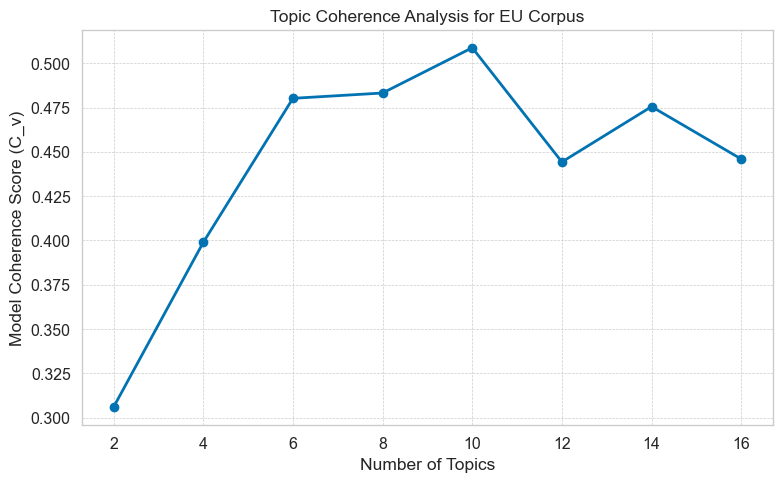

In [21]:
# plotting optimizedd for thesis visualizations
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

# Colorblind-friendly palette
color_palette = sns.color_palette("colorblind")

# Set seaborn style for academic paper
sns.set(style="whitegrid", context="paper", font_scale=1.3)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_palette)

topic_range = list(range(2, 18, 2))
coherence_scores = []
id2word = dictionary

for num in topic_range:
    lda_model = LdaModel(
        corpus=corpus, id2word=id2word, num_topics=num,
        chunksize=2000, alpha='auto', eta='auto', passes=20, iterations=400, random_state = 42
    )
    coherence = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
    coherence_scores.append(coherence.get_coherence())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xlabel("Number of Topics")
plt.ylabel("Model Coherence Score (C_v)")
plt.title("Topic Coherence Analysis for EU Corpus")
plt.xticks(topic_range)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### 3.1.2 Training

In [22]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
id2word = dictionary

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    per_word_topics=True,
    minimum_probability=0.0, 
    random_state=42
)

## 3.2 Explore topics

In [23]:
top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.2772.
[([(0.026190579, 'cooperation'),
   (0.01809522, 'strengthen'),
   (0.01803956, 'partnership'),
   (0.015867917, 'security'),
   (0.015746053, 'development'),
   (0.015061009, 'international'),
   (0.0142651675, 'trade'),
   (0.013909916, 'digital'),
   (0.012139627, 'promote'),
   (0.011579966, 'technology'),
   (0.010078191, 'sustainable'),
   (0.01002445, 'enhance'),
   (0.009637798, 'particular'),
   (0.008996919, 'joint'),
   (0.008953995, 'importance'),
   (0.008711137, 'infrastructure'),
   (0.008532584, 'implementation'),
   (0.008356365, 'exchange'),
   (0.008178741, 'opportunity'),
   (0.00807229, 'agree')],
  -0.8979274967090107),
 ([(0.019741684, 'clean_industrial_deal'),
   (0.018746914, 'decarbonisation'),
   (0.01814697, 'industrial'),
   (0.016698487, 'competitiveness'),
   (0.011721308, 'clean'),
   (0.011363726, 'deal'),
   (0.010808065, 'innovation'),
   (0.009827703, 'growth'),
   (0.009633614, 'competition'),
   (0.008883637, 'acti

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence 
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.321850418282845

Coherence Score:  0.48659090906238944


In [25]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, 
                        corpus, 
                        id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.093862  0.057344       1        1  20.093822
1      0.060540 -0.031419       2        1  16.593987
5     -0.096788 -0.123051       3        1  14.128951
6      0.072958  0.180739       4        1  13.325942
0     -0.114656 -0.016511       5        1   9.182862
8      0.195680 -0.099756       6        1   7.657213
3     -0.052561  0.114078       7        1   6.010758
4      0.114406  0.048146       8        1   5.312840
2     -0.000077 -0.126141       9        1   4.871476
9     -0.085640 -0.003429      10        1   2.822148, topic_info=            Term        Freq       Total Category  logprob  loglift
94           tax  104.000000  104.000000  Default  30.0000  30.0000
80      resource  113.000000  113.000000  Default  29.0000  29.0000
10        budget  100.000000  100.000000  Default  28.0000  28.0000
95      taxation   57.000000   57.000000  Default  27.0000  27.0000
140  cooperation   86.000000   86.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
13     challenge    4.236405   63.141679  Topic10  -4.8957   0.8660
517   contribute    3.919955   53.852850  Topic10  -4.9734   0.9475
426          fit    3.816021   45.083514  Topic10  -5.0003   1.0984
133   commitment    3.902219   59.308015  Topic10  -4.9779   0.8465
149      digital    3.864618   63.038192  Topic10  -4.9876   0.7758

[497 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
619       1  0.080015      abroad
619       2  0.480088      abroad
619       3  0.160029      abroad
619      10  0.160029      abroad
1         1  0.183334  accelerate
...     ...       ...         ...
278       2  0.115782         wto
278       3  0.173673         wto
278       4  0.173673         wto
278       7  0.057891         wto
278       8  0.231564         wto

[2060 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 6, 7, 1, 9, 4, 5, 3, 10])

In [26]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

prepared_vis = gensimvis.prepare(lda_model, corpus, id2word)
print(prepared_vis.topic_coordinates)

              x         y  topics  cluster       Freq
topic                                                
7     -0.093862  0.057344       1        1  20.093810
1      0.060540 -0.031419       2        1  16.594033
5     -0.096788 -0.123051       3        1  14.128687
6      0.072958  0.180739       4        1  13.325957
0     -0.114656 -0.016511       5        1   9.182920
8      0.195680 -0.099756       6        1   7.642088
3     -0.052561  0.114078       7        1   6.010774
4      0.114406  0.048146       8        1   5.328063
2     -0.000077 -0.126141       9        1   4.871509
9     -0.085640 -0.003429      10        1   2.822160


In [27]:
for i in range(lda_model.num_topics):
    print(f"Topic {i}: {[word for word, _ in lda_model.show_topic(i, topn=10)]}")

Topic 0: ['clean_industrial_deal', 'decarbonisation', 'industrial', 'competitiveness', 'clean', 'deal', 'innovation', 'growth', 'competition', 'action_plan']
Topic 1: ['importer', 'simplification', 'sme', 'taxonomy', 'scope', 'report', 'information', 'import', 'apply', 'implement']
Topic 2: ['tax', 'taxation', 'trade', 'fair', 'framework', 'single_market', 'opportunity', 'digital', 'pillar', 'common']
Topic 3: ['european_parliament', 'parliament', 'vote', 'think', 'look', 'long', 'fit_package', 'finance', 'people', 'deal']
Topic 4: ['steel', 'epp_group', 'revenue', 'social_climate_fund', 'current', 'fit_package', 'agree', 'share', 'opinion', 'amendment']
Topic 5: ['cooperation', 'strengthen', 'partnership', 'security', 'development', 'international', 'trade', 'digital', 'promote', 'technology']
Topic 6: ['mep', 'social_climate_fund', 'allowance', 'cover', 'aviation', 'fuel', 'emission_trading_system', 'group', 'emission_trading', 'vote']
Topic 7: ['hydrogen', 'go', 'know', 'thank', 'le

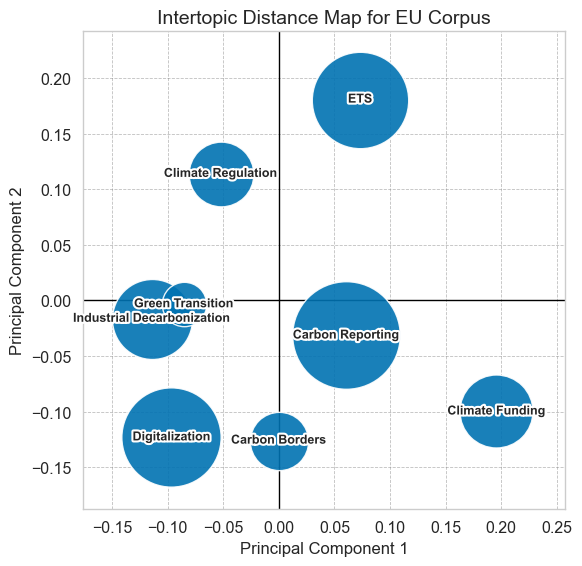

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patheffects import withStroke

# ─── 1. PREP DATA ───────────────────────────────────────────────────────────────
# define df
df_coords = prepared_vis.topic_coordinates.reset_index()
df_coords = df_coords.rename(columns={'Freq': 'topic_size', 'topic': 'topic_id'})

# Filter out topic 4 and 7 (noise topics)
df_coords = df_coords[(df_coords['topic_id'] != 7) & (df_coords['topic_id'] !=4)].copy()

# Map final topic labels
topic_labels = {
    0: "Industrial Decarbonization",
    1: "Carbon Reporting",
    2: "Carbon Borders",  
    3: "Climate Regulation",
    5: "Digitalization",
    6: "ETS",
    8: "Climate Funding", 
    9: "Green Transition"
}
df_coords['label'] = df_coords['topic_id'].map(topic_labels)

# Scale bubble areas
size_scale = 6000
df_coords['scaled_size'] = (df_coords['topic_size'] / df_coords['topic_size'].max()) * size_scale

# ─── 2. STYLING ─────────────────────────────────────────────────────────────────
sns.set(style="whitegrid", context="paper", font_scale=1.3)
unique_clusters = df_coords['cluster'].nunique()
palette = ["#0072b2"] + sns.color_palette("colorblind", unique_clusters - 1)

# Determine plot limits with a margin
x_min, x_max = df_coords['x'].min(), df_coords['x'].max()
y_min, y_max = df_coords['y'].min(), df_coords['y'].max()
x_margin = (x_max - x_min) * 0.2
y_margin = (y_max - y_min) * 0.2

# ─── 3. PLOT ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 7))

# Background & quadrant lines
ax.grid(which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.5)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Scatter bubbles + center labels with halo effect
for _, row in df_coords.iterrows():
    c = palette[int(row['cluster']) - 1]
    ax.scatter(row['x'], row['y'],
               s=row['scaled_size'],
               color=c,
               edgecolors='white',
               linewidth=1,
               alpha=0.9,
               zorder=2)
    
    halo = withStroke(linewidth=3, foreground='white')
    ax.text(row['x'], row['y'],
            row['label'],
            ha='center', va='center',
            fontsize=9, weight='bold',
            path_effects=[halo],
            zorder=3)

# ─── 4. FINAL TOUCHES ───────────────────────────────────────────────────────────
ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(y_min - y_margin, y_max + y_margin)

ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.set_title("Intertopic Distance Map for EU Corpus", fontsize=14)

ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.savefig("eu_map_final.png", dpi=300)
plt.show()

# 4. Topic Exploration

taken from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document

## 4.1 What is the Dominant topic and its percentage contribution in each document

In [114]:
import pandas as pd

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        if row:  # Ensure row is not empty
            topic_num, prop_topic = row[0]  # Only take the dominant topic (highest contribution)
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])

            # Fix: Use pd.concat() instead of append()
            new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], 
                                   columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
            sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)

    return sent_topics_df

# Call function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)

# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7,0.6947,"hydrogen, go, like, know, thank, people, think...","[bruno, dear, colleague, russia, aggression, c..."
1,1,5,0.9141,"cooperation, partnership, strengthen, trade, i...","[second, india, trade, technology, council, tt..."
2,2,1,0.9971,"importer, simplification, scope, sme, taxonomy...","[european, adopt, new, package, proposal, simp..."
3,3,2,0.4996,"tax, taxation, trade, steel, clean_industrial_...","[today, present, theclean, industrial_deal, bo..."
4,4,7,0.9996,"hydrogen, go, like, know, thank, people, think...","[madame, president, honourable_member, honour,..."
5,5,4,0.9988,"resource, budget, revenue, new_resource, billi...","[today, propose, establish, generation, resour..."
6,6,0,0.9985,"decarbonisation, clean_industrial_deal, compet...","[urgently, address_challenge, climate_change, ..."
7,7,7,0.5069,"hydrogen, go, like, know, thank, people, think...","[lady_gentleman, good, morning, everybody, gre..."
8,8,1,0.6223,"importer, simplification, scope, sme, taxonomy...","[line, theeuropean, green, dealand, objective,..."
9,9,1,0.7889,"importer, simplification, scope, sme, taxonomy...","[publishesreporte, obligationsfor, carbon_bord..."


## 4.2 The most representative sentence for each topic

In [139]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9989,"decarbonisation, clean_industrial_deal, competitiveness, china, clean, industrial, deal, drive, ...","[pleasure, honour, open, forum, bring, distinguished, guest, event, bear, testimony, mutual, int..."
1,1,0.9994,"importer, simplification, scope, sme, taxonomy, instrument, import, information, report, apply","[propose, omnibus, legislation, sustainability, rule, recent, competitiveness_compass, set, visi..."
2,2,0.9989,"tax, taxation, trade, steel, clean_industrial_deal, framework, competitiveness, present, single_...","[thank, dear, kadri, invitation, prime_minister, wever, minister, president, diependaele, dear, ..."
3,3,0.9961,"parliament, european_parliament, vote, fit_package, finance, mep, think, deal, conference, ambition","[follow, deal, reach, glasgow, mep, lead, parliament, delegation, comment, outcome, negotiation,..."
4,4,0.9988,"resource, budget, revenue, new_resource, billion, nextgenerationeu, contribution, mff, fit_packa...","[today, propose, establish, generation, resource, budget, put, forward, new_source, revenue, bas..."
5,5,0.9997,"cooperation, partnership, strengthen, trade, international, digital, development, security, tech...","[build, prosperous, secure, sustainable, future, leader, canada, european_union, meet, today, jo..."
6,6,0.9995,"mep, social_climate_fund, allowance, cover, aviation, fuel, emission_trading_system, group, vote...","[euemissionstrade, system, theeu, emission_trading_system_ets, work, principle, cap, trade, set,..."
7,7,0.9996,"hydrogen, go, like, know, thank, people, think, let, look, happen","[madame, president, honourable_member, honour, happy, honourable_member, wonderful, person, rest..."


## 4.3 Frequency Distribution of Word Counts in Documents

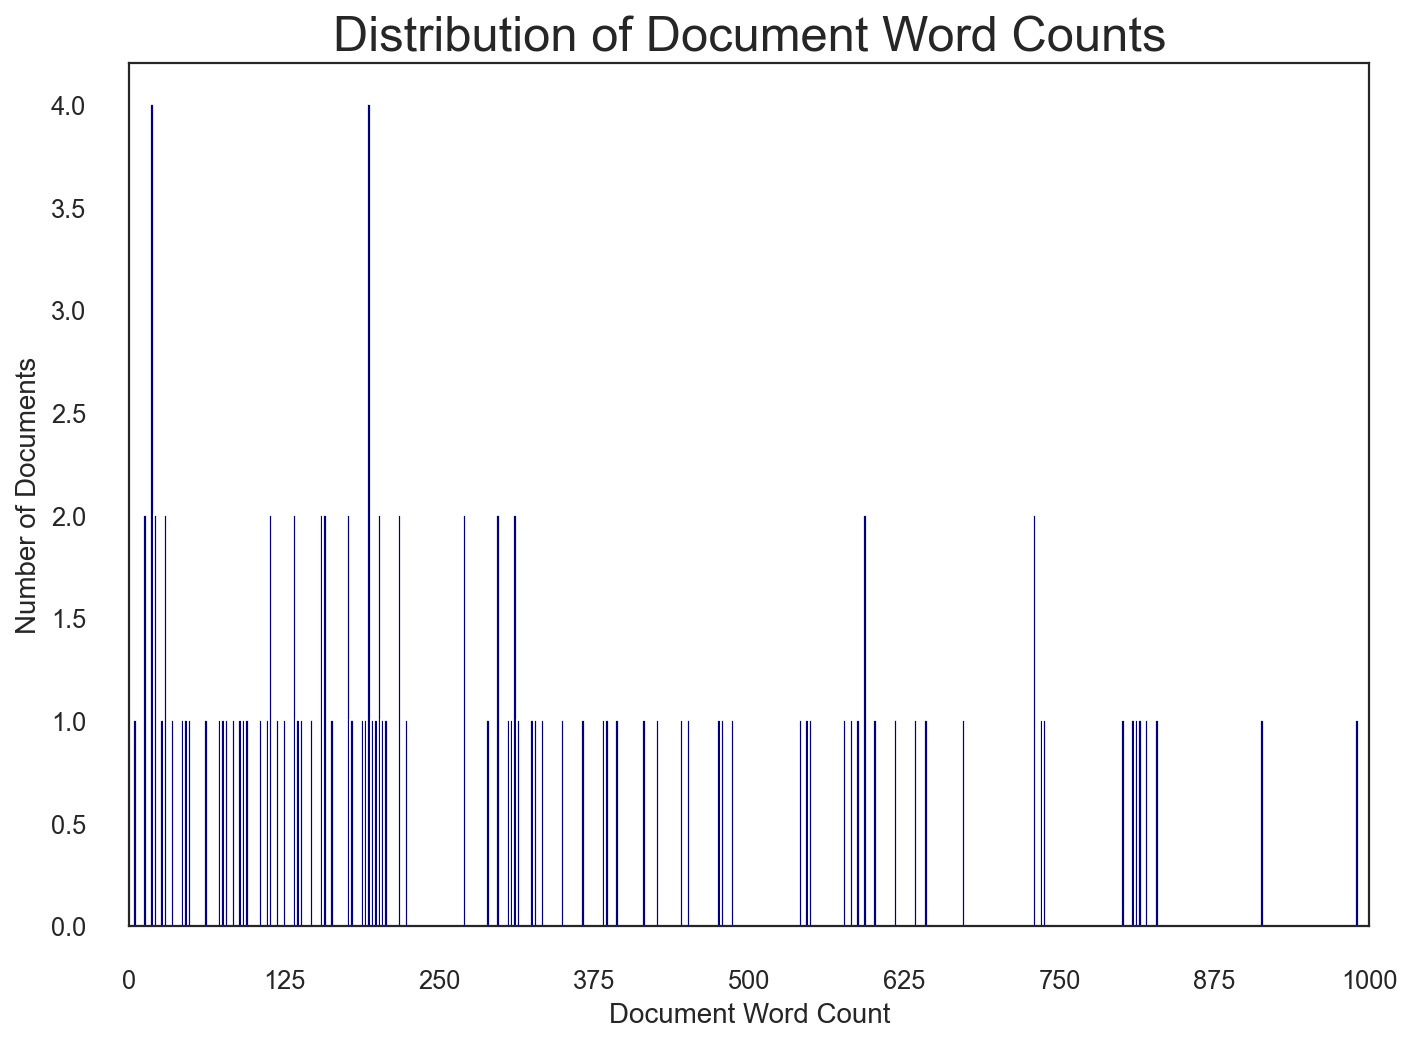

In [116]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
#%matplotlib inline
plt.show()

ValueError: max() arg is an empty sequence

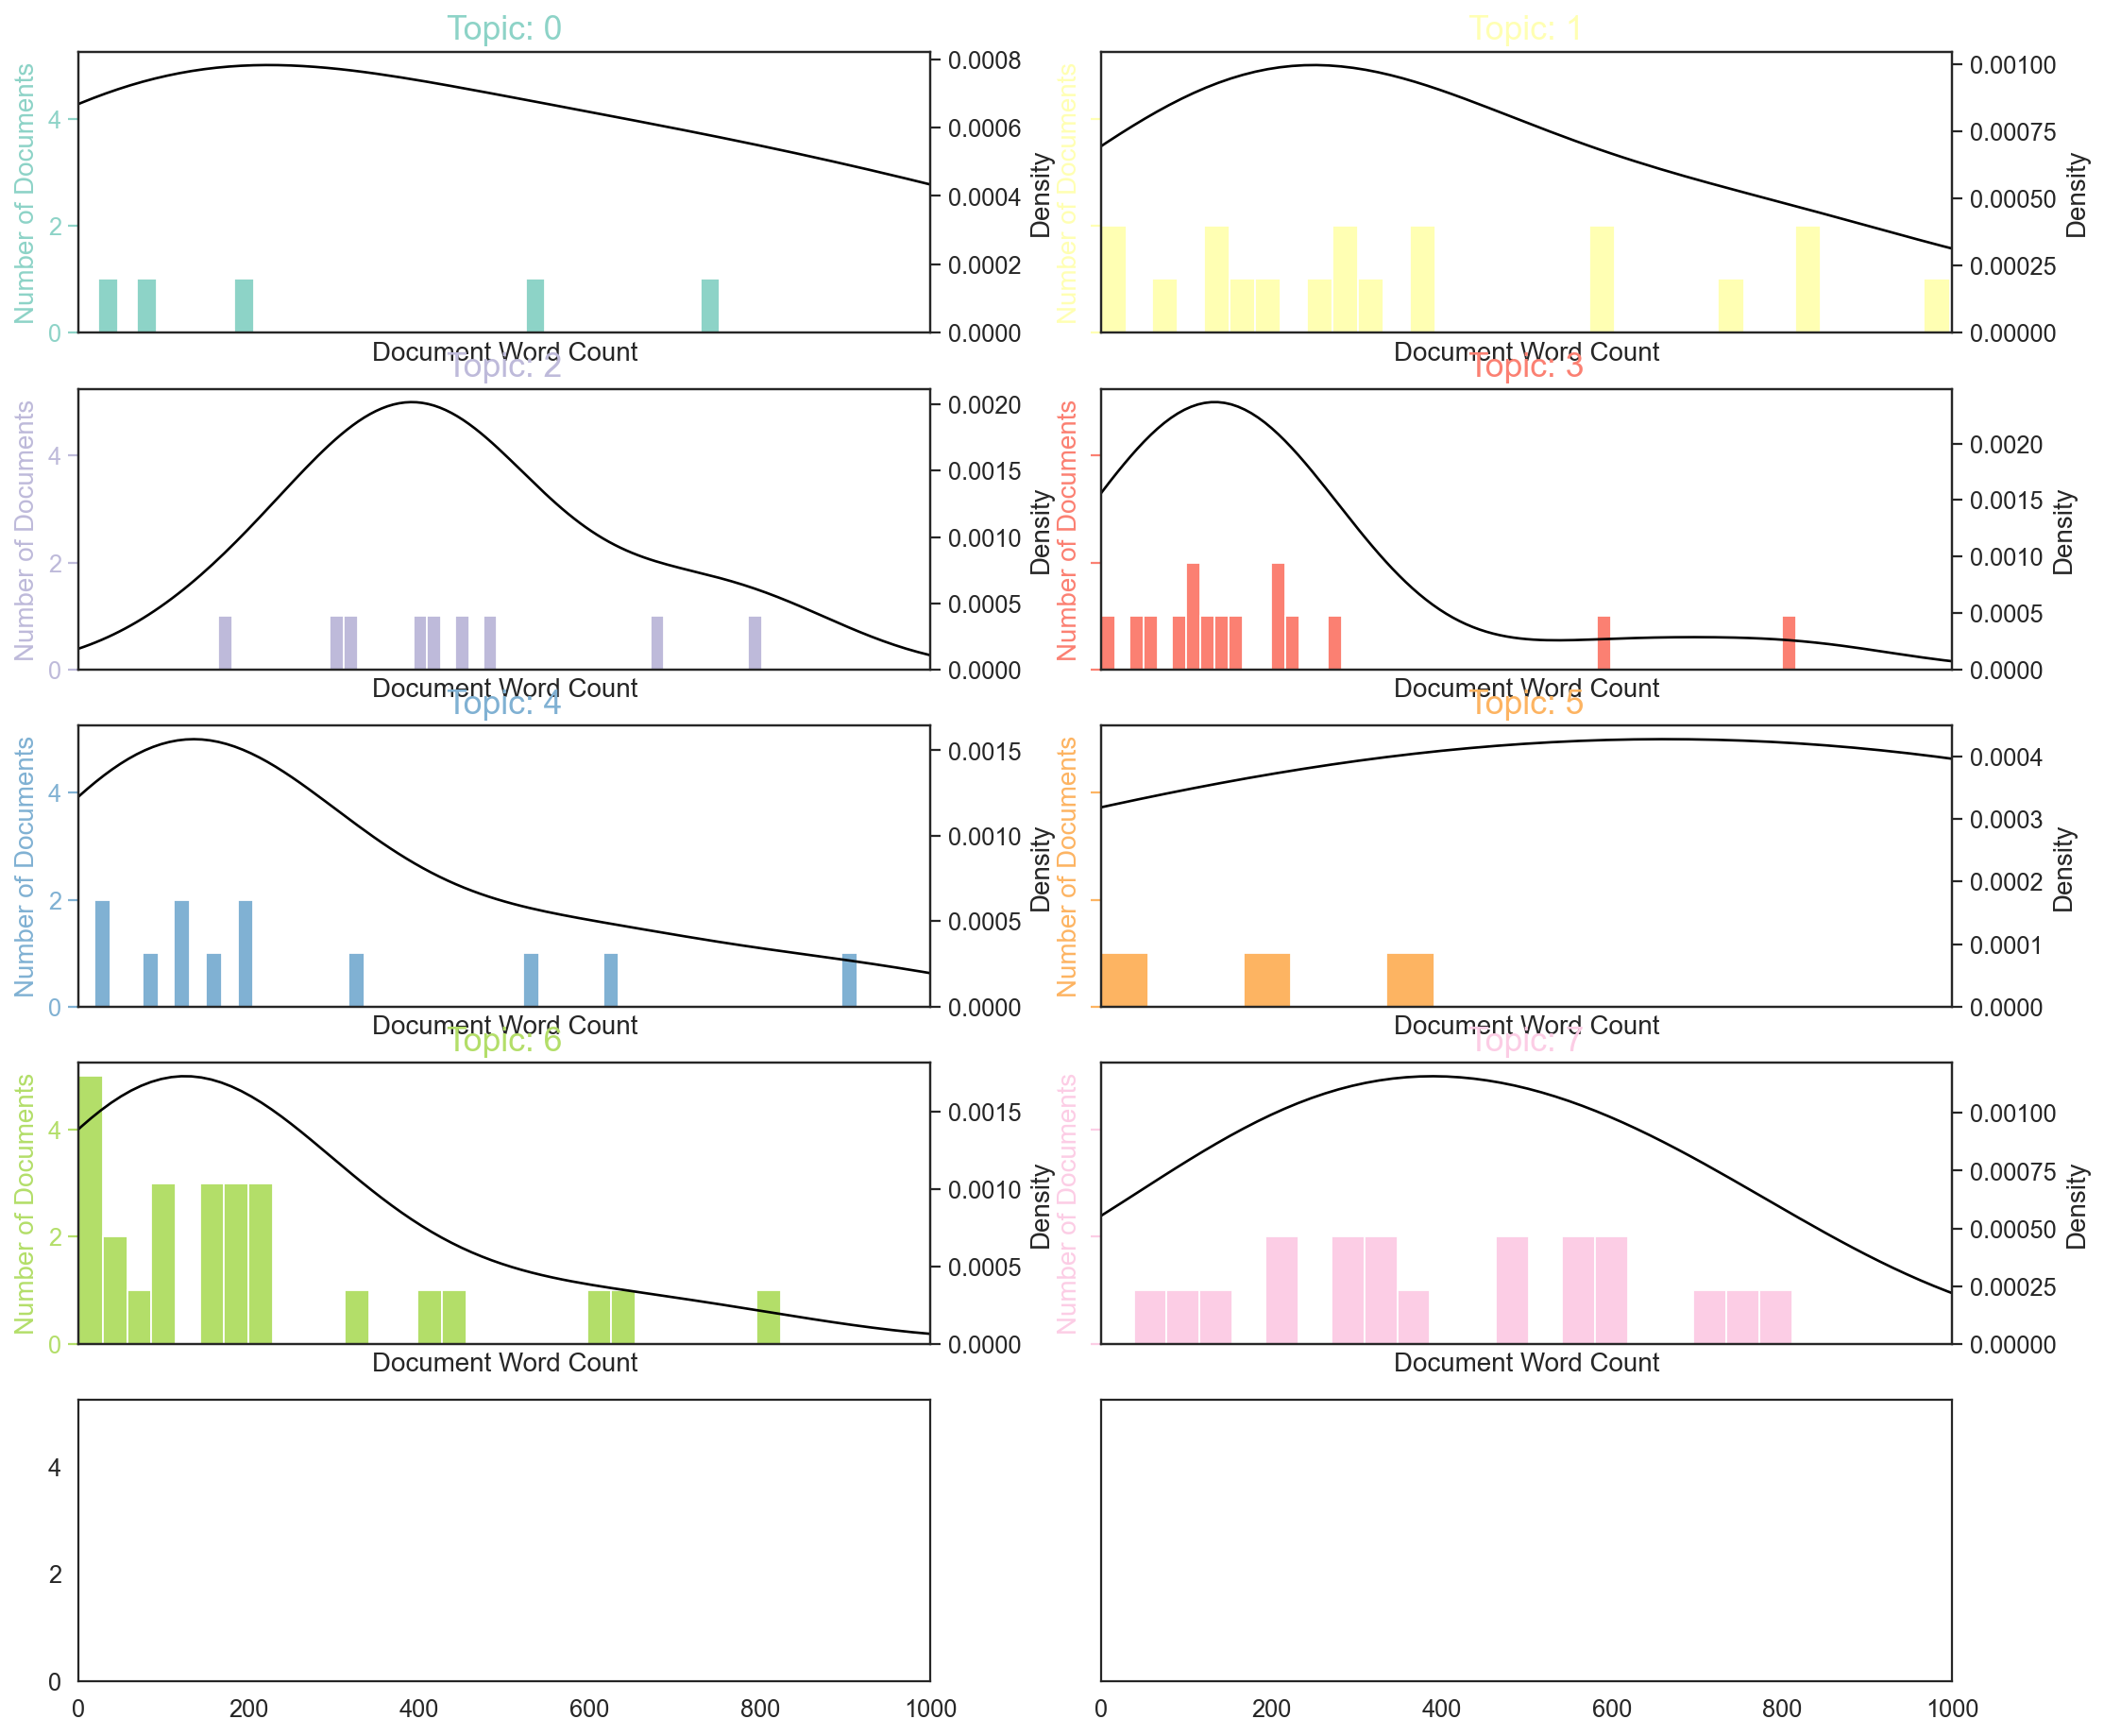

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create a color palette for 10 topics
cols = sns.color_palette("Set3", 10) 

# Create subplots (5 rows, 2 columns for 10 topics)
fig, axes = plt.subplots(5, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

# Iterate over each subplot and topic
for i, ax in enumerate(axes.flatten()):    
    # Subset data for each dominant topic
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    
    # Plot histogram with dynamic binning based on the data
    bins = np.linspace(0, max(doc_lens), 50)  # Dynamically adjust the number of bins
    ax.hist(doc_lens, bins=bins, color=cols[i])
    
    # Set Y-axis label and title with dynamic adjustments
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    
    # Set plot limits and labels
    ax.set_xlim(0, 1000)  # Limit x-axis to avoid excessive outliers
    ax.set_xlabel('Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title(f'Topic: {i}', fontdict={'size': 16, 'color': cols[i]})

# Adjust the overall layout
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# Customize x-ticks for better readability
plt.xticks(np.linspace(0, 1000, 9))

# Add a main title
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)

# Show the plot
plt.show()

## 4.4 Word Clouds of Top N keywords in each topic

IndexError: list index out of range

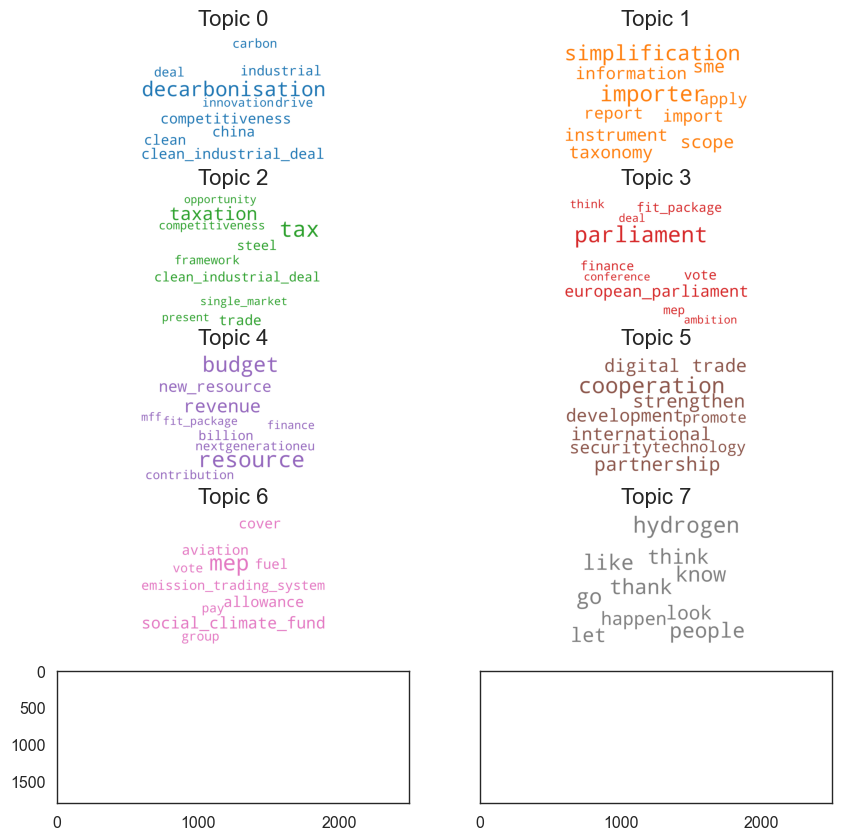

In [119]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=custom_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

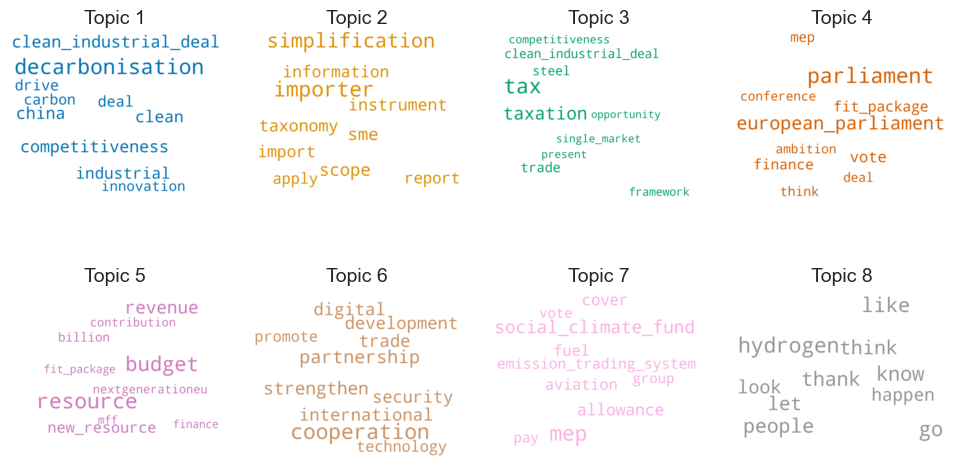

In [128]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np

# Load topics from LDA model
topics = lda_model.show_topics(formatted=False)
num_topics = len(topics)

# Define colorblind-friendly palette
colorblind_palette = sns.color_palette("colorblind", n_colors=num_topics)
cols = [mcolors.to_hex(color) for color in colorblind_palette]  # ✅ fixed line

# WordCloud settings
cloud = WordCloud(
    stopwords=custom_stopwords,
    background_color='white',
    max_font_size = 100, 
    width=1000,
    height=800,
    max_words=10,
    prefer_horizontal=1.0,
    colormap=None  # custom colors will be applied per topic
)

# Grid layout
cols_per_row = 4
rows = int(np.ceil(num_topics / cols_per_row))
fig, axes = plt.subplots(rows, cols_per_row, figsize=(10, rows * 3))
axes = axes.flatten()

# Optional: topic label mapping
# topic_labels = {1: "Carbon Leakage", 2: "Digitalisation", ... }

# Create each word cloud
for i, ax in enumerate(axes):
    if i < num_topics:
        topic_words = dict(topics[i][1])
        cloud.color_func = lambda *args, **kwargs: cols[i]  # 🎨 apply color
        cloud.generate_from_frequencies(topic_words)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title(f"Topic {i + 1}", fontsize=14)  # or: topic_labels.get(i+1, f"Topic {i+1}")
        ax.axis('off')
    else:
        ax.axis('off')  # hide extra axes if any

# Global style settings
sns.set(style="white", context="paper", font_scale=2.2)
plt.tight_layout()
plt.show()

## 4.5 Word Counts of Topic Keywords

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## 4.6 Sentence Chart Colored by Topic

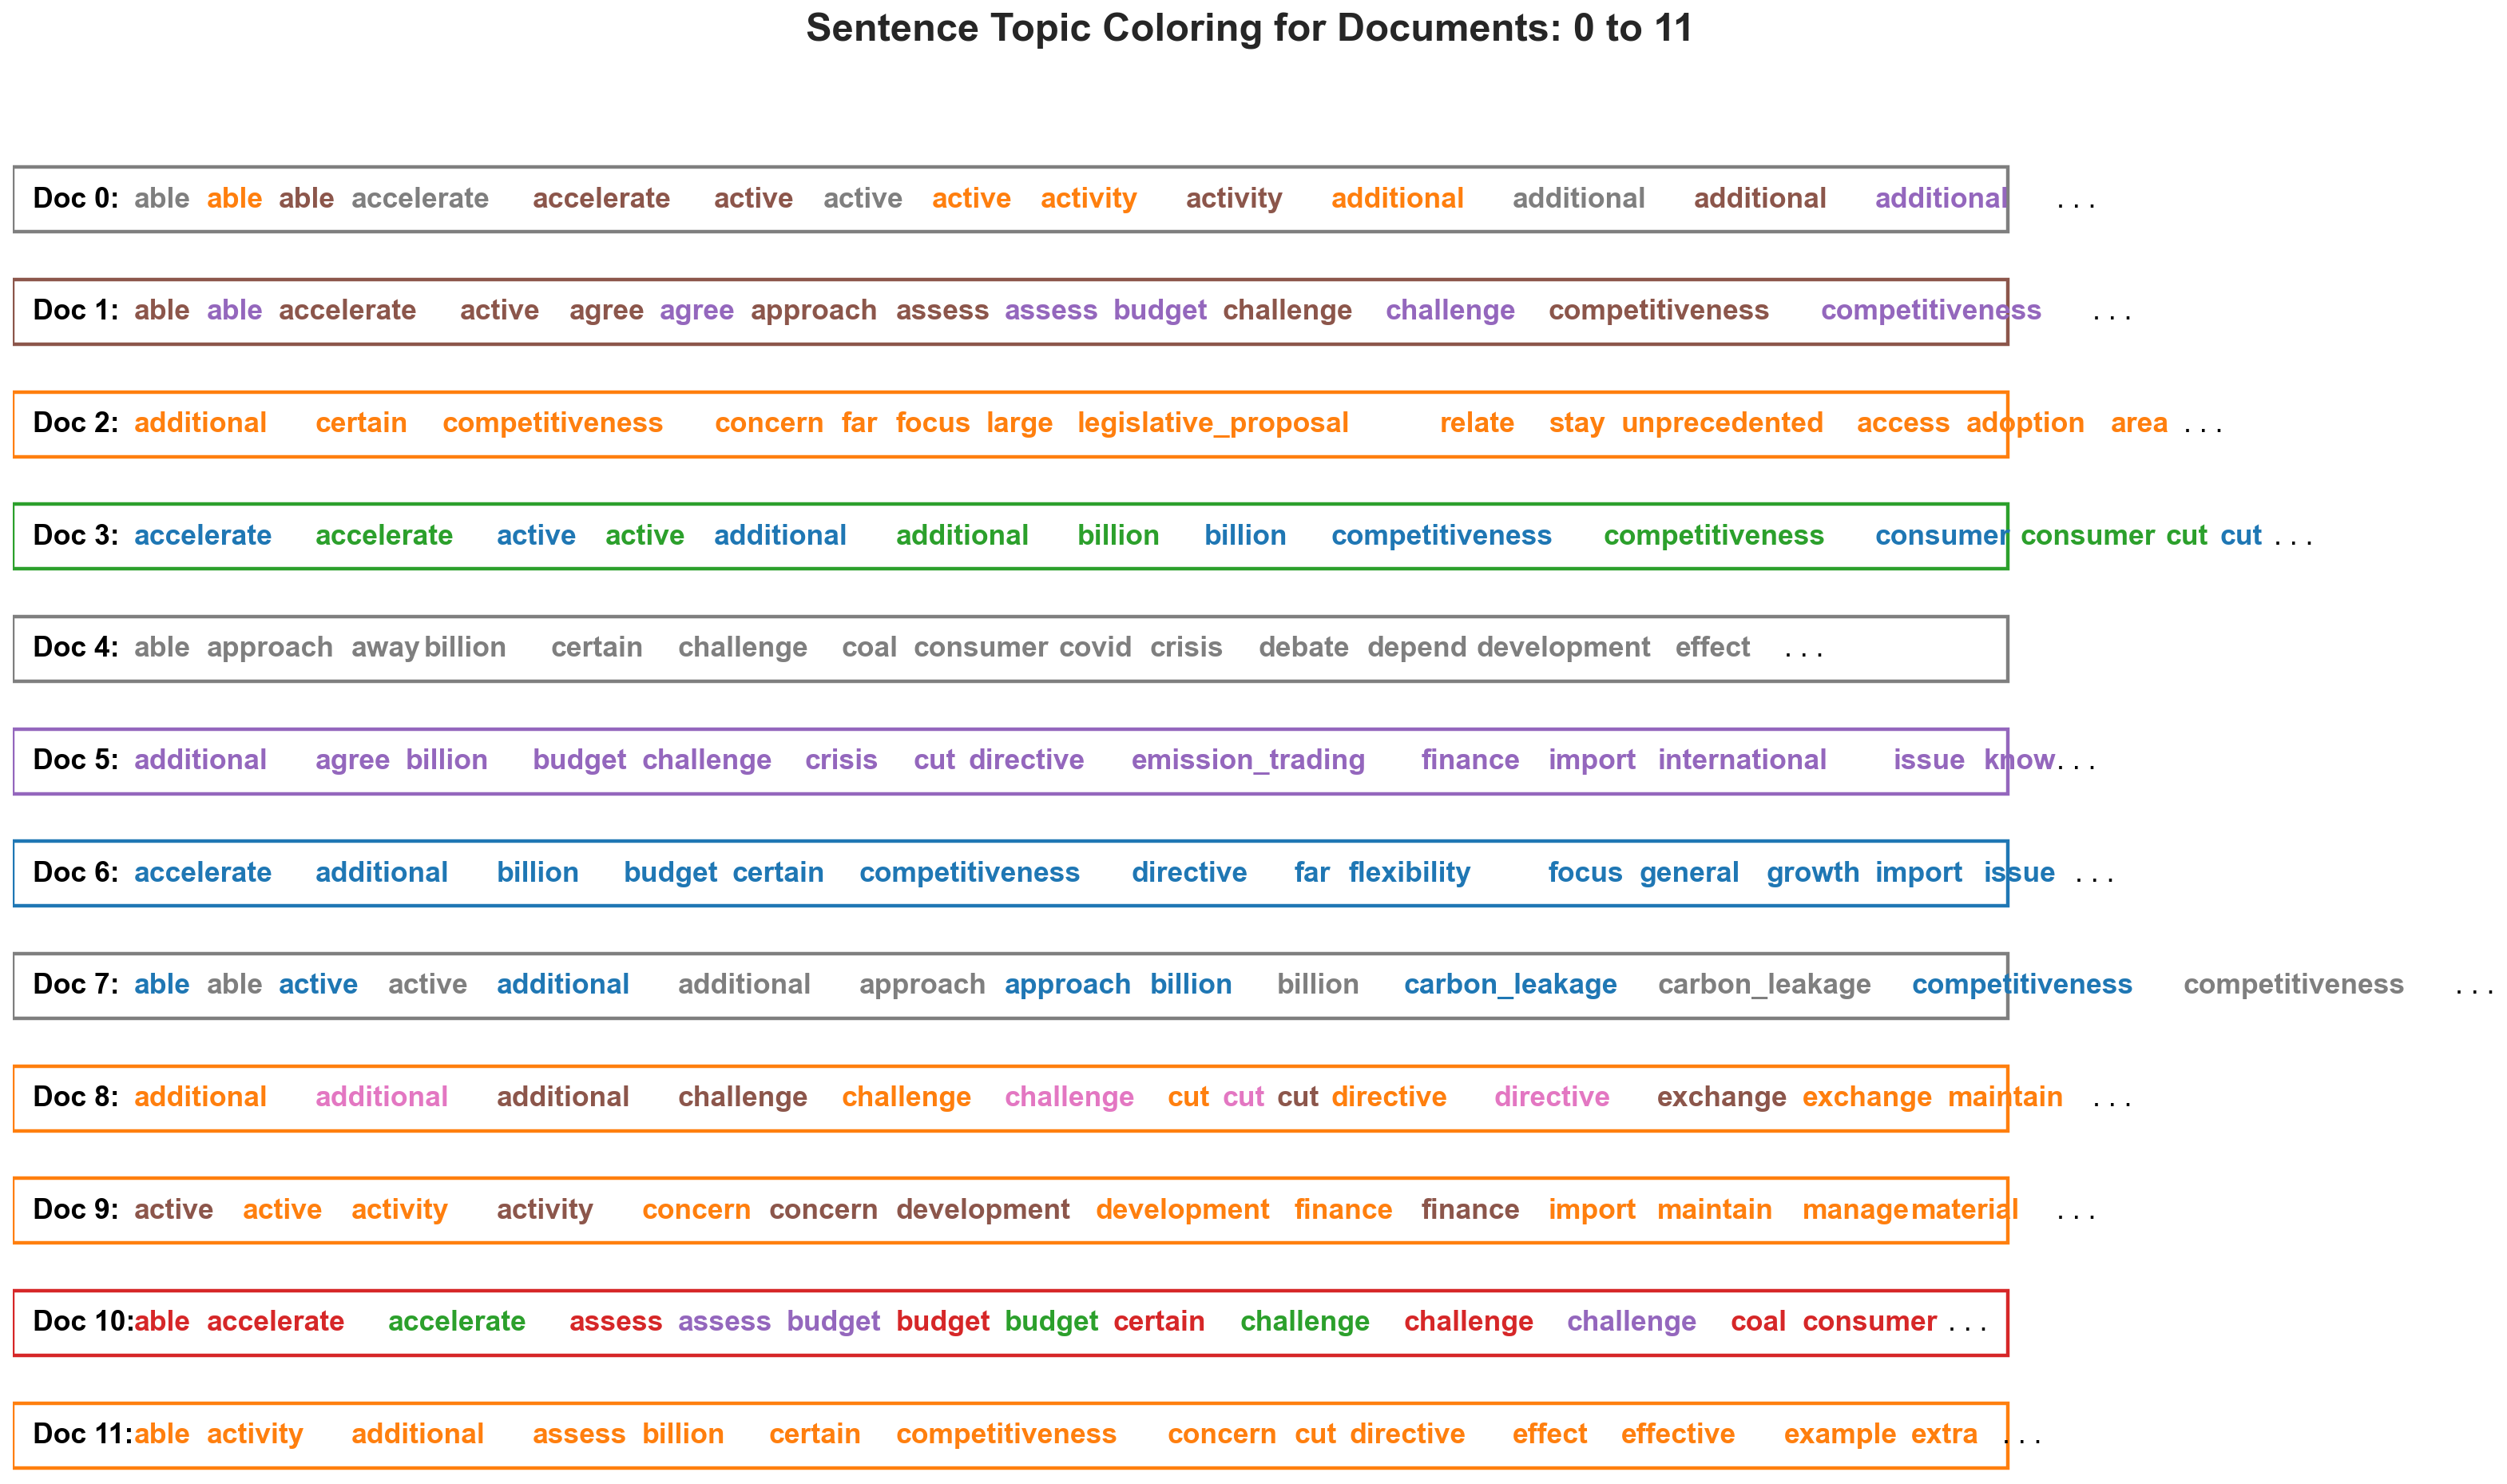

In [130]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            #print(f'debug{lda_model[corp_cur]}')
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            #topic_percs, wordid_topics = lda_model[corp_cur]
            #print(f'wordidtopics {wordid_topics}')
            word_dominanttopic = [(lda_model.id2word[wd], topic_id) for wd, topic in wordid_topics for topic_id in topic] # updated
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

## 4.7 What are the most discussed topics in the documents?

In [131]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [132]:
topic_percs, wordid_topics, wordid_phivalues = lda_model[corpus]
print(topic_percs)

ValueError: too many values to unpack (expected 3)

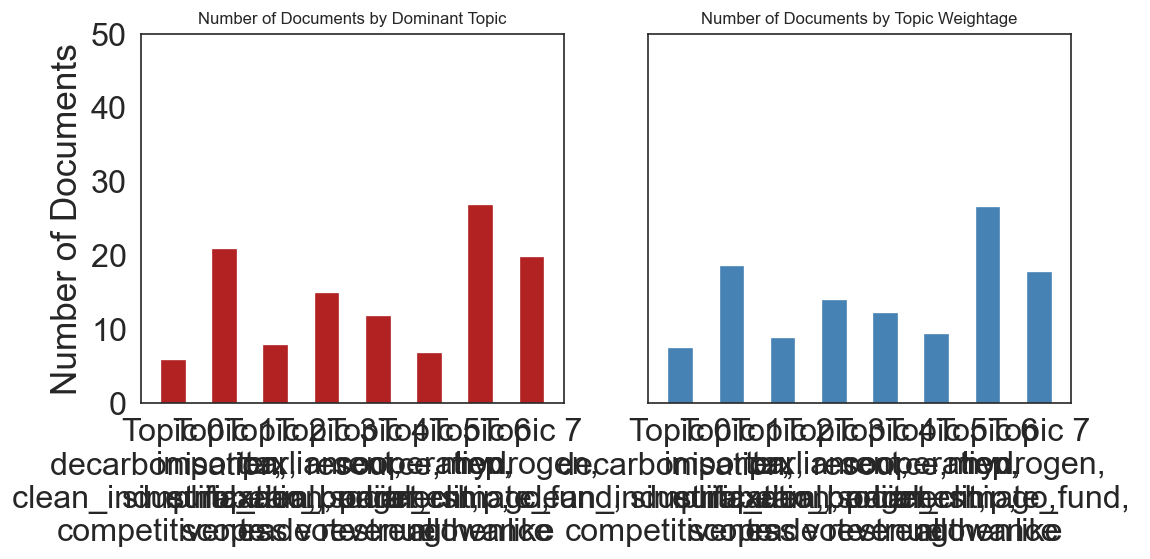

In [138]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 50)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## 4.8 13. t-SNE Clustering Chart

In [136]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics)) 
             # plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 114 samples in 0.005s...
[t-SNE] Computed neighbors for 114 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 114 / 114
[t-SNE] Mean sigma: 0.455434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.701454
[t-SNE] KL divergence after 900 iterations: 0.171343


Loading BokehJS ...